## Capstone Project – The Battle of Neighborhoods

### Introduction
The Gym, Health and Fitness Clubs industry in New York has benefited in recent years from increased awareness about the benefits of exercise. Over the five years to 2018, powered by strong growth in per capita disposable income, industry revenue is expected to increase at an annualized rate of 0.8% to reach $3.1 billion, including an increase of 1.4% in 2018 alone. In terms of such tremendous market potential, gym industry is attracting more and more value investors to make investments, especially in the New York City, which is the most populous city with the largest population in the United States. 

Before entrepreneurs to start their business in the Gym, Health and Fitness Clubs industry, they need to find out where they would open it? What would they consider when selecting a location? By exploring gyms, fitness clubs in major parts of New York City, this project is to figure out what kind of neighborhood of gyms and fitness clubs is for the success of a gym with sound analysis.


### Data
For this project, the following data was utilized:
- **New York City geographical data**: contains information of Boroughs, Neighborhoods along with their latitude and longitude.  This dataset is used to explore the neighborhoods of New York City and exists for free on the web (https://cocl.us/new_york_dataset).
- **Foursquare API**: by using this API, we can get all the venues in each neighborhood and filter these venues to get gym and fitness clubs.


Before we get the data and start exploring, let's import or download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


### 1. Download and Explore New York Neighborhoods Dataset

Define a function to download the New York neighborhoods dataset and convert it to the Pandas DataFrame

In [3]:
def get_NY_data():
    response = requests.get("http://cocl.us/new_york_dataset").json() #get the respose data as a Python object, which is dictionary
    #All relevant data is in the "features" key, which is basically a list of neighborhoods. So, let's define a new vairable that inclues this data
    neighborhoods_data = response['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

    # instantiate the dataframe
    NY_data = pd.DataFrame(columns=column_names)
    #loop through the data and fill the dataframe one row at a time.
    for data in neighborhoods_data:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        NY_data = NY_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return NY_data

    

In [4]:
#Get NY data
NY_data = get_NY_data()

In [5]:
NY_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NY_data['Borough'].unique()),
        NY_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


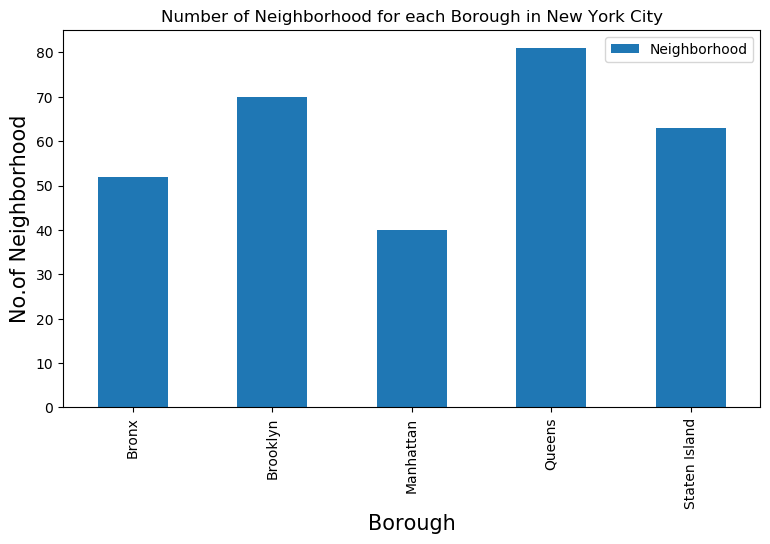

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
NY_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It shows that Queens includes largest number of Neighborhoods. It may raise the questiong that *does Queens have the largest number of gyms?* Let's solve this in the later section. So far we have explored the New York City Neighborhood data, getting the geographical coordinates which is going to be used to find the nearby gyms by interacting with Foursquare API. 

### 2. Exploring Gyms - Intercation with Foursquare API

#### 2.1 Find gym venues in each neighborhood, given the neighborhood's latitude and longitude
Let's define a function to intract with Foursquare API and get Gym venues within a radius of 1000 metres for a given latitude and longitude of each Neighborhood. Below function will return us the name, ID and geographical coordinates of each gym.

In [8]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'ASDAF0D2D0HI3XNVE3UHOVZ4ZIMU2NHJZZWS3EABMTWDLLIW' # your Foursquare ID
CLIENT_SECRET = 'UG514A31UGIFGHI53JY5OZ1O1DD5ZNWZF2MZKQM2SZZ0YTZ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [17]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'Y21TCFXYZVHEFSWZJZ5ZCPLEAOGTE1JLUSPL3FZK4MWPHPP3' # your Foursquare ID
CLIENT_SECRET = 'WCGPAOIW3WOKSLZVEORYRQIEDMZTDQEQUA4HJ0UYFFYDV2R5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
def get_gyms(lat, lng):
    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.id','venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_gyms = nearby_venues[nearby_venues['categories'].str.contains('Gym|Fitness')].copy() #Filter for Gym venues
    
    nearby_gyms.drop('categories',axis=1, inplace=True)
    
    return nearby_gyms


Add Borough and Neiborhood information for each gym.

In [12]:
# prepare neighborhood list that contains gyms
column_names=['Borough', 'Neighborhood', 'ID','Name','Latitude','Longitude']
NY_gym=pd.DataFrame(columns=column_names)

for row in NY_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    gyms = get_gyms(Latitude,Longitude)
    
    for gym in gyms.values.tolist():
        name, id, lat,lng = gym
        NY_gym = NY_gym.append({'Borough': Borough,
                               'Neighborhood':Neighborhood,
                               'Name': name,
                                'Latitude':lat,
                                'Longitude':lng,
                               'ID':id}, ignore_index=True)
    

In [134]:
NY_gym.sort_values(by=['Borough','Neighborhood'],inplace=True)
NY_gym.head(10)

,Borough,Neighborhood,ID,Name,Latitude,Longitude
12,Bronx,Bedford Park,532ad23e498e87bb1035acf5,Crunch,40.872635,-73.874847
13,Bronx,Bedford Park,5cf7f63cb9b37b002c7b4d0f,Blink Fitness,40.873893,-73.888768
14,Bronx,Bedford Park,4c5ee8ae7f661b8d94464f1c,APEX - Lehman College,40.874849,-73.893296
55,Bronx,Belmont,52af0e3c11d2fb9a346ce0f7,Blink Fitness,40.859373,-73.898316
56,Bronx,Belmont,52af0dc711d21e1625464d63,Blink Fitness,40.859482,-73.898520
520,Bronx,Bronxdale,4c518ceb9426c9283e19f373,Powerhouse Gym,40.844493,-73.857738
60,Bronx,Castle Hill,4c38a7920a71c9b6d30241c9,Bronx YMCA,40.812425,-73.846126
441,Bronx,Claremont Village,5632f45c498ef690c483ecda,Retro Fitness,40.831190,-73.905395
37,Bronx,Clason Point,4c38a7920a71c9b6d30241c9,Bronx YMCA,40.812425,-73.846126
0,Bronx,Co-op City,4c2a235d97d00f47fa7e42ea,24 Hour Fitness,40.867818,-73.824984


In [136]:
NY_gym.shape[0]

546

In [144]:
NY_gym.to_csv('NY_gym.csv', index=False)

Now we know that there are 546 gyms in New York City.

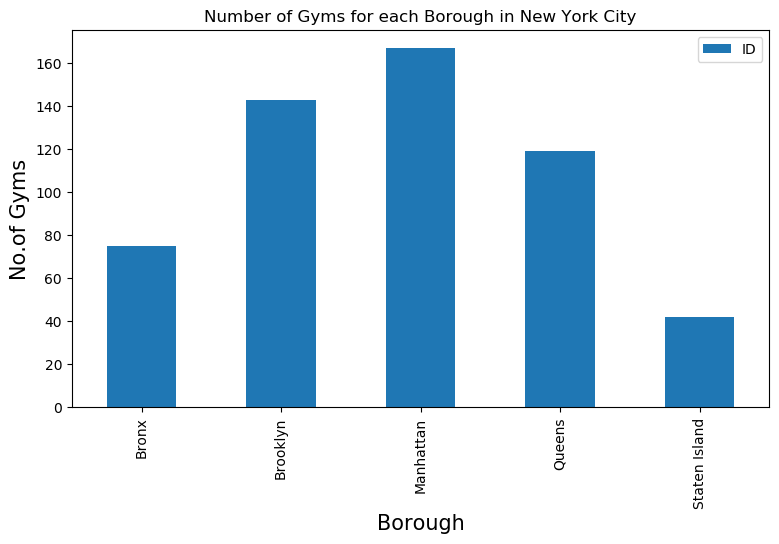

In [68]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Gyms for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Gyms', fontsize=15)
#giving a bar plot
NY_gym.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It shows that Manhattan has the largest number of gym. This answers the question we have at the end of section 1 that, although Queens has largest number of neiborghood, it doesn't have largest number of gym. 

Similarly, let's find out the top 10 neighorborhoods that have most gyms:

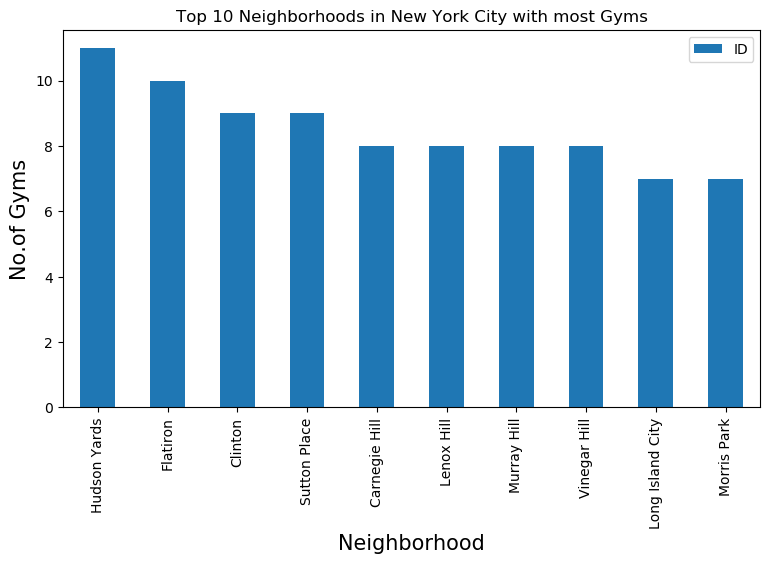

In [70]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Top 10 Neighborhoods in New York City with most Gyms')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Gyms', fontsize=15)
#giving a bar plot
NY_gym.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

After exploring the distribution of gyms by Borough and Neighborhood, we could ask question like, *what could impact location of a gym?* or *what kind of neighborhood does a gym owner would like choose to open the business?*. This is also the purpose of this entire project to help entrepreneurs to find a right location to business in the Gym, Health and Fitness Clubs industry.

To answer this question, we will focus on the good rating gyms (rating >= 9.0), to see what are the common nearby venues surounding the good rating gyms. Next we will add more gym venue details like rating, likes and tips from Foursquare API. 

Manhattan is the most densely populated borough in New York City, and that population density carries over to offices and co-working spaces. There is an incredibly high demand for gym/fitness spots in Manhattan. For entrepreneurs to start gym business, **we will look into the gyms in Manhattan in the following analysis.**

In [80]:
Manhattan_gyms = NY_gym[NY_gym['Borough']=='Manhattan']
Manhattan_gyms.head()

,Borough,Neighborhood,ID,Name,Latitude,Longitude
218,Manhattan,Battery Park City,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995
219,Manhattan,Battery Park City,4a6e331af964a52031d41fe3,Equinox Tribeca,40.714099,-74.009686
220,Manhattan,Battery Park City,58a253c830ecc66c9e5b40a0,The Class by Taryn Toomey,40.712753,-74.008734
221,Manhattan,Battery Park City,5a697271ad178907f79be157,Crunch - FiDi,40.708614,-74.010013
222,Manhattan,Battery Park City,4a2f3322f964a520b6981fe3,Equinox Wall Street,40.707273,-74.010543


In [172]:
Manhattan_gyms.shape[0]

167

In [ ]:
There are 167 gyms located in Manhattan

#### 2.1 Find good gyms for further analysis by adding Gym details (rating, number of likes and tips), given the gym venue IDs.

Firstly, lets' define a function to pull gym details inlcuding likes, rating and tips from Foursquare

In [18]:
def get_gym_details(venue_id):        

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    
    venues = results['response']['venue']
    
    nearby_venues = json_normalize(venues) # flatten JSON
    
    # filter columns
    filtered_columns = ['rating', 'likes.count', 'id','tips.count']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # clean columns
    nearby_venues.columns = [col.split(".")[0] for col in nearby_venues.columns]  
    
    return nearby_venues


Create a dataframe to store the detail information for all the manhattan gyms

In [81]:
#Define an empty dataframe to store all the information for each gym
column_names=['Borough', 'Neighborhood', 'ID','Name','Latitude','Longitude','Rating','Likes','Tips']
Mahanttan_gyms_all = pd.DataFrame(columns=column_names)

for row in Manhattan_gyms.values.tolist():
    Borough,Neighborhood,ID,Name,Latitude,Longitude=row 
    gym_details = get_gym_details(ID)
    for detail in gym_details.values.tolist():
        rating, likes, id, tips = detail
        Mahanttan_gyms_all  = Mahanttan_gyms_all .append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': ID,
                                                'Name' : Name, 
                                                'Latitude':Latitude,
                                                'Longitude':Longitude,
                                                'Rating' : rating,
                                                'Likes' : likes,
                                                'Tips' : tips                                                
                                               }, ignore_index=True)

In [82]:
Mahanttan_gyms_all

,Borough,Neighborhood,ID,Name,Latitude,Longitude,Rating,Likes,Tips
0,Manhattan,Battery Park City,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,9.0,174,14
1,Manhattan,Battery Park City,4a6e331af964a52031d41fe3,Equinox Tribeca,40.714099,-74.009686,8.8,250,21
2,Manhattan,Battery Park City,58a253c830ecc66c9e5b40a0,The Class by Taryn Toomey,40.712753,-74.008734,9.1,19,2
3,Manhattan,Battery Park City,5a697271ad178907f79be157,Crunch - FiDi,40.708614,-74.010013,8.7,20,1
4,Manhattan,Battery Park City,4a2f3322f964a520b6981fe3,Equinox Wall Street,40.707273,-74.010543,8.8,311,50
5,Manhattan,Carnegie Hill,574dc71c498ef19a1c178913,Equinox East 92nd Street,40.782500,-73.950580,9.3,72,12
6,Manhattan,Carnegie Hill,5158e6bde4b079b32ba7e7fd,Crank NYC,40.783209,-73.950862,8.8,48,9
7,Manhattan,Carnegie Hill,4c9a873ad4b1b1f79dffd035,92nd Street Y May Center,40.783108,-73.952758,8.5,74,10
8,Manhattan,Carnegie Hill,52b9c263498ebbff8b240197,ChaiseFitness,40.783065,-73.952648,8.3,22,3
9,Manhattan,Carnegie Hill,4a97e23df964a520db2920e3,Equinox East 85th Street,40.778001,-73.954143,8.8,207,30


In [83]:
Mahanttan_gyms_all.shape[0]

167

Confirmed that there are still 167 gyms in Manhattan after adding more details. 

In [84]:
Mahanttan_gyms_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
Borough         167 non-null object
Neighborhood    167 non-null object
ID              167 non-null object
Name            167 non-null object
Latitude        167 non-null float64
Longitude       167 non-null float64
Rating          167 non-null float64
Likes           167 non-null object
Tips            167 non-null object
dtypes: float64(3), object(6)
memory usage: 11.9+ KB


We need to convert the Likes and Tips to the float.

In [85]:
Mahanttan_gyms_all['Tips']=Mahanttan_gyms_all['Tips'].astype('float64')
Mahanttan_gyms_all['Likes']=Mahanttan_gyms_all['Likes'].astype('float64')

In [24]:
Mahanttan_gyms_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
Borough         167 non-null object
Neighborhood    167 non-null object
ID              167 non-null object
Name            167 non-null object
Latitude        167 non-null float64
Longitude       167 non-null float64
Rating          167 non-null float64
Likes           167 non-null float64
Tips            167 non-null float64
dtypes: float64(5), object(4)
memory usage: 11.9+ KB


**Next, we need to find "good gym" reviewed by customers.** However, it is subjective to define what is a good gym, it could depend on the rating, count of likes or count of Tips. Let's look at the correlation among these three variables first as below:

In [86]:
Mahanttan_gyms_all[['Rating','Likes','Tips']].corr()

,Rating,Likes,Tips
Rating,1.000000,0.288911,0.305661
Likes,0.288911,1.000000,0.608718
Tips,0.305661,0.608718,1.000000


It shows that correlation between rating and likes or tips are both low. **Here we define the *good gyms* as the ones with rating greater than or equal to 8.5 with at least 50 likes and at least 1 tip.**

There are some duplicates in the dataframe, because the same gym could be in the overlap of different neighborhood, hence we need to remove the duplicates.

In [87]:
Manhattan_gyms2=Mahanttan_gyms_all.drop(['Neighborhood','Borough'],axis=1)
Manhattan_gym_vf = Manhattan_gyms2.drop_duplicates()
Manhattan_gym_vf.sort_values(by=['Name'])

,ID,Name,Latitude,Longitude,Rating,Likes,Tips
102,5672e6a5498ea77d7c6aafe4,305 Fitness MIDTOWN,40.746790,-73.982885,9.0,52.0,6.0
7,4c9a873ad4b1b1f79dffd035,92nd Street Y May Center,40.783108,-73.952758,8.5,74.0,10.0
161,4a6f77a1f964a5203ed61fe3,Asphalt Green,40.779062,-73.944095,8.8,123.0,36.0
93,4cf6ae55d3a8a1cd71a9d243,Astral Fitness & Wellness Center,40.876705,-73.906372,7.3,6.0,1.0
77,521c185b11d26fe322a0b139,Barry's Bootcamp,40.763501,-73.962023,9.5,45.0,1.0
17,4d2cc14bb47d2c0fd1608594,Barry's Bootcamp,40.741647,-73.995769,9.2,443.0,64.0
82,5a6ca12395d986525fa14684,Barry's Bootcamp,40.775306,-73.979857,8.5,18.0,1.0
157,5a3ea6ac610f044748e42d0c,Blink Fitness,40.848562,-73.936941,7.1,5.0,2.0
92,55f751ca498eacc0307d1cfe,Blink Fitness,40.877271,-73.905595,7.4,32.0,3.0
15,51b35586498e4fcfa012f235,Blink Fitness,40.810539,-73.951460,8.1,126.0,23.0


In [88]:
good_gyms = Manhattan_gym_vf[(Mahanttan_gyms_all['Rating']>=8.5) & (Mahanttan_gyms_all['Likes']>=50) &(Mahanttan_gyms_all['Tips']>0)].reset_index()
good_gyms = good_gyms.rename(columns={'ID':'Gym_ID', 'Name':'Gym_name','Latitude':'Gym_lat','Longitude':'Gym_lng'})
good_gyms

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,index,Gym_ID,Gym_name,Gym_lat,Gym_lng,Rating,Likes,Tips
0,0,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,9.0,174.0,14.0
1,1,4a6e331af964a52031d41fe3,Equinox Tribeca,40.714099,-74.009686,8.8,250.0,21.0
2,4,4a2f3322f964a520b6981fe3,Equinox Wall Street,40.707273,-74.010543,8.8,311.0,50.0
3,5,574dc71c498ef19a1c178913,Equinox East 92nd Street,40.782500,-73.950580,9.3,72.0,12.0
4,7,4c9a873ad4b1b1f79dffd035,92nd Street Y May Center,40.783108,-73.952758,8.5,74.0,10.0
5,9,4a97e23df964a520db2920e3,Equinox East 85th Street,40.778001,-73.954143,8.8,207.0,30.0
6,17,4d2cc14bb47d2c0fd1608594,Barry's Bootcamp,40.741647,-73.995769,9.2,443.0,64.0
7,18,4a72e5fef964a52050db1fe3,Chelsea Piers Fitness,40.746645,-74.010057,8.8,493.0,100.0
8,23,46b78e2cf964a520bc491fe3,Manhattan Plaza Health Club (MPHC),40.759967,-73.994585,8.7,108.0,34.0
9,24,4eb5c125f9f40c39c596bb4a,Mark Fisher Fitness - Ninja Clubhouse,40.756836,-73.994719,9.2,72.0,14.0


It shows that there are 41 good gyms for our further nearby venue investigation. 

#### 2.3 Explore the nearby venues of each good gym in Manhattan

Let's create a function to explore the venues within 500 meters for each good gym we got above.

In [44]:
def getNearbyVenues(ids,names, latitudes, longitudes, radius=500):
    limit =100
    
    venues_list=[]
    for id, name, lat, lng in zip(ids, names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            
            id,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    
    return(nearby_venues)

Now write the code to run the above function on each good gym and create a new dataframe called good_gym_nearby_venues.

In [89]:
good_gym_nearby_venues = getNearbyVenues(
                                   ids=good_gyms['Gym_ID'],
                                   names=good_gyms['Gym_name'],
                                   latitudes=good_gyms['Gym_lat'],
                                   longitudes=good_gyms['Gym_lng']
                                  )

In [90]:
good_gym_nearby_venues.columns = ['Gym ID', 'Gym Name','Gym Latitude', 'Gym Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category']
good_gym_nearby_venues.head()

,Gym ID,Gym Name,Gym Latitude,Gym Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,9/11 Memorial North Pool,40.712077,-74.013187,Memorial Site
1,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,National September 11 Memorial & Museum (Natio...,40.711451,-74.013433,Memorial Site
2,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,One World Trade Center,40.713069,-74.013133,Building
3,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,Institute of Culinary Education,40.712399,-74.015971,Cooking School
4,541a2341498e51ce1037963a,Equinox Brookfield Place,40.712704,-74.014995,Hudson Eats,40.712666,-74.015901,Food Court


Let's check the size of the resulting dataframe

In [91]:
good_gym_nearby_venues.shape

(3888, 8)

Let's check how many venues were returned for each Gym

In [92]:
good_gym_nearby_venues.groupby(['Gym ID']).count()

,Gym Name,Gym Latitude,Gym Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Gym ID,,,,,,,
42af6f80f964a5205a251fe3,100,100,100,100,100,100,100
45938647f964a52045401fe3,100,100,100,100,100,100,100
46b78e2cf964a520bc491fe3,100,100,100,100,100,100,100
49bd4e25f964a52067541fe3,100,100,100,100,100,100,100
49c9439bf964a5204e581fe3,100,100,100,100,100,100,100
49fa353af964a520da6d1fe3,85,85,85,85,85,85,85
49fce426f964a520ed6e1fe3,100,100,100,100,100,100,100
4a2f3322f964a520b6981fe3,100,100,100,100,100,100,100
4a68fb35f964a52064cb1fe3,98,98,98,98,98,98,98


Let's find out how many unique categories can be curated from all the returned venues

In [93]:
print('There are {} uniques categories.'.format(len(good_gym_nearby_venues['Venue Category'].unique())))

There are 313 uniques categories.


### 3. Analyze Each Gym

In [95]:
# one hot encoding
gym_onehot = pd.get_dummies(good_gym_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gym_onehot['Gym ID'] = good_gym_nearby_venues['Gym ID']
gym_onehot['Gym Name'] = good_gym_nearby_venues['Gym Name'] 
 

# move neighborhood column to the first column
fixed_columns = [gym_onehot.columns[-1]] + list(gym_onehot.columns[:-1])
gym_onehot = gym_onehot[fixed_columns]

gym_onehot.head()

,Gym Name,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sp

In [96]:
gym_onehot.shape

(3888, 315)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [97]:
gym_grouped = gym_onehot.groupby(['Gym ID','Gym Name']).mean().reset_index()
gym_grouped

,Gym ID,Gym Name,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speak

Let's confirm the new size

In [98]:
gym_grouped.shape

(41, 315)

#### Let's print each good gym along with top 5 most common venues

First, let's write a function to sort the venues in descending order.

In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [100]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Gym ID','Gym Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Gym ID'] = gym_grouped['Gym ID']
neighborhoods_venues_sorted['Gym Name'] = gym_grouped['Gym Name']


for ind in np.arange(gym_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(gym_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Gym ID,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,42af6f80f964a5205a251fe3,Equinox East 44th Street,Coffee Shop,Hotel,Japanese Restaurant,Grocery Store,Sandwich Place
1,45938647f964a52045401fe3,Equinox Sports Club New York,Italian Restaurant,Theater,Plaza,Concert Hall,Café
2,46b78e2cf964a520bc491fe3,Manhattan Plaza Health Club (MPHC),Coffee Shop,Gym / Fitness Center,Wine Shop,Gym,Theater
3,49bd4e25f964a52067541fe3,Equinox SoHo,Italian Restaurant,Mediterranean Restaurant,Café,Clothing Store,Cosmetics Shop
4,49c9439bf964a5204e581fe3,Equinox Greenwich Avenue,Italian Restaurant,Coffee Shop,Bakery,Park,Café
5,49fa353af964a520da6d1fe3,Crunch Fitness - 34th Street,Coffee Shop,Bar,Café,Mexican Restaurant,Pizza Place
6,49fce426f964a520ed6e1fe3,Equinox Columbus Circle,Concert Hall,Jazz Club,Hotel,Bakery,Performing Arts Venue
7,4a2f3322f964a520b6981fe3,Equinox Wall Street,Coffee Shop,Pizza Place,Hotel,Cocktail Bar,Falafel Restaurant
8,4a68fb35f964a52064cb1fe3,Equinox East 63rd Street,Italian Restaurant,Hotel,Gym / Fitness Center,Boutique,Coffee Shop
9,4a6e331af964a52031d41fe3,Equinox Tribeca,Coffee Shop,Hotel,Gym,Bakery,Memorial Site


It's showing the venues like public transportation, food stores, are most common venues around these good gyms, which make sense that it is convenient for customer to commute after daily work and get food after workout. In order to further analyze the pattern or grouping of these good gyms, we will perform the K-means clustering analysis in next section.

### 3. Cluster Gyms: K-means Clustering Analysis

In [101]:
gym_grouped.head()

,Gym ID,Gym Name,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speak

**We draw the *elbow curve* to find the optimal K value for the k-mean clustering analysis.**

In [102]:
gym_grouped_clustering = gym_grouped.drop(['Gym ID','Gym Name'],1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(gym_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

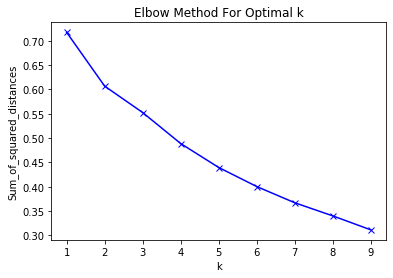

In [103]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [104]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [105]:
good_gyms_coordinates=good_gyms[['Gym_ID','Gym_lat','Gym_lng']]
good_gyms_coordinates.rename(columns={'Gym_ID':'Gym ID'},inplace=True)
good_gyms_coordinates

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Gym ID,Gym_lat,Gym_lng
0,541a2341498e51ce1037963a,40.712704,-74.014995
1,4a6e331af964a52031d41fe3,40.714099,-74.009686
2,4a2f3322f964a520b6981fe3,40.707273,-74.010543
3,574dc71c498ef19a1c178913,40.782500,-73.950580
4,4c9a873ad4b1b1f79dffd035,40.783108,-73.952758
5,4a97e23df964a520db2920e3,40.778001,-73.954143
6,4d2cc14bb47d2c0fd1608594,40.741647,-73.995769
7,4a72e5fef964a52050db1fe3,40.746645,-74.010057
8,46b78e2cf964a520bc491fe3,40.759967,-73.994585
9,4eb5c125f9f40c39c596bb4a,40.756836,-73.994719


In [106]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

good_gym_merged = good_gyms_coordinates

# merge to add latitude/longitude for each good gym
good_gym_merged = good_gym_merged.join(neighborhoods_venues_sorted.set_index('Gym ID'), on='Gym ID')

good_gym_merged # check the last columns!


,Gym ID,Gym_lat,Gym_lng,Cluster Labels,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,541a2341498e51ce1037963a,40.712704,-74.014995,0,Equinox Brookfield Place,Park,Hotel,Coffee Shop,Wine Shop,Gym
1,4a6e331af964a52031d41fe3,40.714099,-74.009686,0,Equinox Tribeca,Coffee Shop,Hotel,Gym,Bakery,Memorial Site
2,4a2f3322f964a520b6981fe3,40.707273,-74.010543,0,Equinox Wall Street,Coffee Shop,Pizza Place,Hotel,Cocktail Bar,Falafel Restaurant
3,574dc71c498ef19a1c178913,40.782500,-73.950580,1,Equinox East 92nd Street,Coffee Shop,Pizza Place,Gym,Café,Japanese Restaurant
4,4c9a873ad4b1b1f79dffd035,40.783108,-73.952758,1,92nd Street Y May Center,Coffee Shop,Pizza Place,Gym,Café,Wine Shop
5,4a97e23df964a520db2920e3,40.778001,-73.954143,1,Equinox East 85th Street,Italian Restaurant,Pizza Place,Bar,Bakery,Coffee Shop
6,4d2cc14bb47d2c0fd1608594,40.741647,-73.995769,1,Barry's Bootcamp,Coffee Shop,Gym / Fitness Center,Grocery Store,Yoga Studio,Cycle Studio
7,4a72e5fef964a52050db1fe3,40.746645,-74.010057,2,Chelsea Piers Fitness,Art Gallery,Park,Italian Restaurant,Bus Station,Coffee Shop
8,46b78e2cf964a520bc491fe3,40.759967,-73.994585,0,Manhattan Plaza Health Club (MPHC),Coffee Shop,Gym / Fitness Center,Wine Shop,Gym,Theater
9,4eb5c125f9f40c39c596bb4a,40.756836,-73.994719,0,Mark Fisher Fitness - Ninja Clubhouse,Theater,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio


Finally, let's visualize the resulting clusters

In [107]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [108]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(good_gym_merged['Gym_lat'], good_gym_merged['Gym_lng'], good_gym_merged['Gym ID'], good_gym_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Next, let's examine the Clusters and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [109]:
good_gym_merged.loc[good_gym_merged['Cluster Labels'] == 0, good_gym_merged.columns[[0,4] + list(range(5, good_gym_merged.shape[1]))]]

,Gym ID,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,541a2341498e51ce1037963a,Equinox Brookfield Place,Park,Hotel,Coffee Shop,Wine Shop,Gym
1,4a6e331af964a52031d41fe3,Equinox Tribeca,Coffee Shop,Hotel,Gym,Bakery,Memorial Site
2,4a2f3322f964a520b6981fe3,Equinox Wall Street,Coffee Shop,Pizza Place,Hotel,Cocktail Bar,Falafel Restaurant
8,46b78e2cf964a520bc491fe3,Manhattan Plaza Health Club (MPHC),Coffee Shop,Gym / Fitness Center,Wine Shop,Gym,Theater
9,4eb5c125f9f40c39c596bb4a,Mark Fisher Fitness - Ninja Clubhouse,Theater,Coffee Shop,Gym / Fitness Center,Hotel,Dance Studio
10,533629bf498ed70d66886dd6,TITLE Boxing Club NYC - Midtown West,Hotel,Theater,Coffee Shop,Gym / Fitness Center,Cocktail Bar
11,568dd8f0498e49b9d660021b,Physique 57,Park,Coffee Shop,Hotel,Pizza Place,Mexican Restaurant
17,4efe614e0e618ea7655927b8,Body & Pole,Coffee Shop,Hotel,Gym / Fitness Center,Hotel Bar,Spa
28,53851395498e2379f6178a0d,Equinox Bryant Park,Theater,Hotel,Coffee Shop,Bakery,Mediterranean Restaurant
30,4a705a19f964a5204ed71fe3,Equinox,Hotel,Indian Restaurant,Art Museum,Food & Drink Shop,Plaza


#### Cluster 2

In [110]:
good_gym_merged.loc[good_gym_merged['Cluster Labels'] == 1, good_gym_merged.columns[[0,4] + list(range(5, good_gym_merged.shape[1]))]]

,Gym ID,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,574dc71c498ef19a1c178913,Equinox East 92nd Street,Coffee Shop,Pizza Place,Gym,Café,Japanese Restaurant
4,4c9a873ad4b1b1f79dffd035,92nd Street Y May Center,Coffee Shop,Pizza Place,Gym,Café,Wine Shop
5,4a97e23df964a520db2920e3,Equinox East 85th Street,Italian Restaurant,Pizza Place,Bar,Bakery,Coffee Shop
6,4d2cc14bb47d2c0fd1608594,Barry's Bootcamp,Coffee Shop,Gym / Fitness Center,Grocery Store,Yoga Studio,Cycle Studio
12,54cd0dab498e6e5d8a9d7866,The Fhitting Room,Gym / Fitness Center,Coffee Shop,Gym,Yoga Studio,Italian Restaurant
13,574da377498ef19a1bd08764,Equinox Gramercy,Indian Restaurant,Bar,Café,Thrift / Vintage Store,Italian Restaurant
14,52a9166611d204ca2a31b144,CityRow,Yoga Studio,Gym / Fitness Center,Cosmetics Shop,Vegetarian / Vegan Restaurant,Bookstore
15,4f9e99f7e4b06064311cf82e,Body Space Fitness Inc,Italian Restaurant,Gym / Fitness Center,Arts & Crafts Store,Steakhouse,Tapas Restaurant
16,586ff8a545c3ed0998f3fcfb,Rumble,Gym / Fitness Center,Yoga Studio,Coffee Shop,Grocery Store,Café
18,4a7ca51ff964a52012ed1fe3,Physique 57,Italian Restaurant,Café,Coffee Shop,Indian Restaurant,Burger Joint


### Cluster 3

In [111]:
good_gym_merged.loc[good_gym_merged['Cluster Labels'] == 2, good_gym_merged.columns[[0,4] + list(range(5, good_gym_merged.shape[1]))]]

,Gym ID,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,4a72e5fef964a52050db1fe3,Chelsea Piers Fitness,Art Gallery,Park,Italian Restaurant,Bus Station,Coffee Shop


### Cluster 4

In [112]:
good_gym_merged.loc[good_gym_merged['Cluster Labels'] == 3, good_gym_merged.columns[[0,4] + list(range(5, good_gym_merged.shape[1]))]]

,Gym ID,Gym Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
32,5672e6a5498ea77d7c6aafe4,305 Fitness MIDTOWN,Korean Restaurant,Bakery,Gym / Fitness Center,Spa,Café
33,544993c4498e8104085787de,CrossFit Solace,Korean Restaurant,Gym / Fitness Center,Spa,Bakery,Japanese Restaurant
